# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   



In [1]:
from copy import deepcopy
import os
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import setup_logger
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import EarlyStopping, ModelCheckpoint

from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.param_scheduler import LRScheduler
from ignite.contrib.metrics import GpuInfo

from tqdm.notebook import tqdm

import pandas as pd

In [ ]:
from tiny_img import download_tinyImg200

data_path = '.'
download_tinyImg200(data_path)

In [3]:
# Create Test directory, mimicking the ImageFolder structure of train
VAL_DIR = 'tiny-imagenet-200/val'
TEST_DIR = 'tiny-imagenet-200/Test'

val_list = pd.read_csv(VAL_DIR + '/val_annotations.txt', sep='\t', header=None)

if not os.path.isdir(TEST_DIR):
    os.mkdir(TEST_DIR)

for x in val_list.iterrows():
    img = x[1][0]
    folder = TEST_DIR + '/' + x[1][1]
    
    if not os.path.isdir(folder):
        os.mkdir(folder)
        
    copyfile(VAL_DIR + '/images' + '/' + img, folder + '/' + img)

## 1. Data Loading and Augmentation

In [4]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)


transforms_train = transforms.Compose([
   transforms.ColorJitter(hue=.05, saturation=.05),
   transforms.RandomHorizontalFlip(),
   transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_val = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

VAL_SIZE = int(1e4)
full_set = datasets.ImageFolder(root='tiny-imagenet-200/train')
train_set, val_set = torch.utils.data.random_split(full_set, (len(full_set)-VAL_SIZE, VAL_SIZE))
train_set = MapDataset(train_set, transforms_train)
val_set = MapDataset(val_set, transforms_val)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

# Test set
test_set = datasets.ImageFolder(root='tiny-imagenet-200/Test')

# The class labels better be the same - else we have a problem
assert test_set.class_to_idx == full_set.class_to_idx, "Test and train labels don't match"

# Transforms on test
test_set = MapDataset(test_set, transforms_val)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=8)

## 2. Model definition

In [5]:
class BasicModule(nn.Module):
    """Basic 2 layer 3x3 convnet block
    
    Contains 2 3*3 convolution layers. If downsampling, the first convolution layer has a stride of 2,
    and the input is passed through a 1*1 convolution layer with stride 2 before adding at the end.
    """
    
    def __init__(self, in_ch, out_ch, downsample=False):
        super(BasicModule, self).__init__()

        if downsample:
            stride = 2
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=2)
        elif in_ch != out_ch:
            stride = 1
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=1)
        else:
            stride = 1
            self.downsample = nn.Identity()
            
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.relu = nn.ReLU(inplace=True)       
        
    def forward(self, input):
        
        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + self.downsample(input)
        out = self.relu(out)
        
        return out

class MyNet(nn.Module):
    """Baby ResNet model
    
    This version includes 4 residual layers and 2 fully connected layers.
    
    Input: 3*64*64 image
    Layer 0: 5*5 convolution with 16 channels and stride 2
    Layer 1: 4 residual blocks of 2 3*3 convolutions with 32 channels
    Layer 2: 4 residual blocks of 2 3*3 convolutions with 64 channels
    Layer 3: 4 residual blocks of 2 3*3 convolutions with 128 channels
    
    FC1: Layer with 500 neurons (and ReLU activation)
    FC2: Layer with 200 neurons
    """
    
    def __init__(self):
        super(MyNet, self).__init__()

        initial_channel = 32
        
        self.layer_0 = nn.Conv2d(3, initial_channel, 5, padding=2, stride=1)
        self.layer_1 = self._make_layer(3, initial_channel, initial_channel*2) # Returns 32 * 32
        self.layer_2 = self._make_layer(10, initial_channel*2, initial_channel*4) # Returns 16 * 16
        self.layer_3 = self._make_layer(10, initial_channel*4, initial_channel*8) # Returns 8 * 8
        #self.layer_4 = self._make_layer(6, 128, 256) # Returns 4 * 4
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(initial_channel * 8, 200)       

    def forward(self, input):
        
        out = self.layer_0(input)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        #out = self.layer_4(out)
        out = self.avg_pool(out)

        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
                
        return out

    def _make_layer(self, n_blocks, in_ch, out_ch, downsample=True):
        
        blocks = [BasicModule(in_ch, out_ch, downsample=downsample)]        
        for i in range(n_blocks - 1):
            blocks.append(BasicModule(out_ch, out_ch))
            
        return nn.Sequential(*blocks)
    

## Initialization

In [6]:
# Select device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Training on {device}')

# Create the net
net1 = MyNet().to(device)

Training on cuda


In [ ]:
# Alternatively, load it from device!
# net1 = MyNet()
# net1.load_state_dict(torch.load('winrar.pth'))
# net1 = net1.to(device)

In [7]:
# Initialize all weights (He initialization)
def init_fn(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
net1 = net1.apply(init_fn)

## Prepare optimizer, trainer and evaluator

In [14]:
# Prepare for optimization
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), weight_decay=1e-4)

# Set up LR scheduling
step_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs = 50, steps_per_epoch = len(train_loader),
                                               pct_start = 0.1, div_factor=1e3, final_div_factor=1)

# Create trainer and evaluator
trainer = create_supervised_trainer(net1, optimizer, loss, device=device)
evaluator = create_supervised_evaluator(
    net1, metrics={"accuracy": Accuracy(), "nll": Loss(loss)}, device=device
)

# Configure logging
trainer.logger = setup_logger("trainer", level = 30)
evaluator.logger = setup_logger("evaluator", level = 30)

## Learning rate scheduler

/home/tadej/miniconda3/envs/DL/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


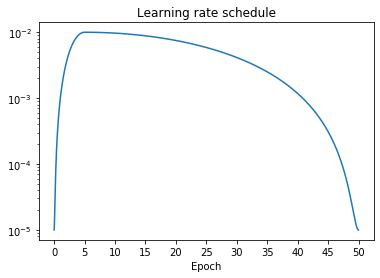

In [15]:
# Set up LR scheduling
TOTAL_EPOCHS = 50
step_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs=TOTAL_EPOCHS, steps_per_epoch=len(train_loader),
                                               max_lr=0.01, pct_start = 0.1, div_factor=1e3, final_div_factor=1)
# Plot the scheduler
sch = deepcopy(step_scheduler)
lr_graph = []

for i in range(TOTAL_EPOCHS*len(train_loader)):
    lr_graph.append(sch.get_lr()[0])
    sch.last_epoch += 1

plt.plot(lr_graph)
plt.yscale('log')
plt.xticks(len(train_loader)*np.arange(TOTAL_EPOCHS+1, step=5), np.arange(TOTAL_EPOCHS+1, step=5))
plt.title('Learning rate schedule')
_ = plt.xlabel('Epoch')

## Logging, checkpointing and early stopping

In [16]:
# Early stopping (after 10 epochs with no improvement)
score_function = lambda engine: -engine.state.metrics['nll']
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

In [16]:
# Configure logging and shit
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    pbar.desc = f"ITERATION - loss: {engine.state.output:.2f}"
    pbar.update(1)

    # Step scheduler
    step_scheduler.step()
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics["accuracy"]
    avg_nll = metrics["nll"]
    time_taken = engine.state.times[Events.EPOCH_COMPLETED.name]
    
    tqdm.write(
        f"Validation Results - Epoch: {engine.state.epoch}  Avg accuracy: {avg_accuracy:.3f}\
        Avg loss: {avg_nll:.3f}  Time taken:{time_taken:.1f}s"
    )
    
    pbar.n = pbar.last_print_n = 0
    

In [16]:
# Checkpointing
score_function = lambda engine: engine.state.metrics['accuracy']
handler = ModelCheckpoint('/tmp/models', 'mm', create_dir=True, n_saved=2,
                     score_function=score_function, score_name="val_acc")
evaluator.add_event_handler(Events.COMPLETED, handler, {'model': net1})

## See summary

In [ ]:
summary(net1, (3, 64, 64))

# RUUUUUUUUUUUUUUUUUUUUUUUUUUUUNNNN!

In [17]:
pbar = tqdm(initial=0, leave=False, total=len(train_loader))
trainer.run(train_loader, max_epochs=1000)

Validation Results - Epoch: 1  Avg accuracy: 0.044        Avg loss: 5.426  Time taken:124.8s
Validation Results - Epoch: 2  Avg accuracy: 0.083        Avg loss: 4.666  Time taken:125.7s
Validation Results - Epoch: 3  Avg accuracy: 0.118        Avg loss: 4.611  Time taken:125.8s
Validation Results - Epoch: 4  Avg accuracy: 0.197        Avg loss: 3.677  Time taken:125.8s
Validation Results - Epoch: 5  Avg accuracy: 0.217        Avg loss: 3.526  Time taken:125.9s


2020-05-27 13:41:27,775 trainer ERROR: Engine run is terminating due to exception: .


KeyboardInterrupt: 

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
# Optionally, save
torch.save(net1.state_dict(), 'winrar.pth')

In [ ]:
evaluator.run(test_loader)
metrics = evaluator.state.metrics
test_accuracy = metrics['accuracy'] # YOUR CODE

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:Prvič moramo vedeti, da je zdravljenje v bolnišnici v vsakem primeru od otroške dobe do pozne starosti smiselno takrat, ko lahko v bolnišnici nudimo zdravljenje, ki ga bolnik doma ne more biti deležen, pa ga zaradi svoje bolezni seveda potrebuje, da ima t. i. indikacijo. Drugič moramo vedeti, da za bolezen covid-19 nimamo nekega uspešnega specifičnega zdravljenja, ki bi zmanjšalo bolezen, izboljšalo preživetje. In tega zdravljenja nimamo niti zunaj bolnišnice niti v bolnišnici.


    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]